In [1]:
import os
import numpy as np
import pystan
from astropy.table import Table
import matplotlib.pyplot as plt
%matplotlib inline
import corner
import random

In [2]:
data=Table.read('../data/LQSO_CASTLES5.csv',format='csv')

In [3]:
allwise=Table.read('../data/QSO_ALLWISE5_CLEANED.csv', format='csv')

In [4]:
data = data.to_pandas()
datanew = data[np.isfinite(data['pmra'])]
allwise = allwise.to_pandas()
allwisenew = allwise[np.isfinite(allwise['pmra'])]

In [5]:
def sigma2(ea,ed,c) : 
    """ the largest eigen value of the covariance matrix defined by
    ea : right ascention error
    ed : declination error
    c  : correlation
    """
    res = np.power(ea,2) + np.power(ed,2) 
    res = res + np.sqrt(np.power(ea-ed,2) + np.power(2*ea*ed*c,2))
    return res/2

def setMu(d):
    """
    set mu, mu_error and mu_norm taking in account the correlation
    """
    d['mu'] = np.sqrt(np.power(d.pmra,2)+np.power(d.pmdec,2))
    d['mu_error'] = np.sqrt(sigma2(d.pmra_error,d.pmdec_error,d.pmra_pmdec_corr))
    d['mu_over_error'] = d.mu/d.mu_error

In [6]:
setMu(datanew)
setMu(allwisenew)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

In [7]:
Nl = len(datanew)
Nq = len(allwisenew)

In [ ]:
bayesmod1 = """
data{
    int<lower=0> Nq; //number of quasars
    int<lower=0> Nl; //number of lens
    vector[Nq] muqhat; //propermotion of qso
    vector[Nl] mulhat; //propermotion of lens
    vector<lower=0>[Nq] sigq; //error on pm of qso
    vector<lower=0>[Nl] sigl; //error on pm of lens
}

parameters{
//population parameters
    real mu1;
    real mu2;   
    real<lower=0> sigma1;
    real<lower=0> sigma2;
    vector<lower=0>[Nq] muq; //propermotion of qso
    vector<lower=0>[Nl] mul; //propermotion of lens
}

model{

    mu1 ~ normal(0,1); 
    mu2 ~ normal(0,1); 
    sigma1 ~ normal(0,1);
    sigma2 ~ normal(0,1);

    muqhat ~ normal(muq, sigq);  
    mulhat ~ normal(mul, sigl);  

    muq ~ lognormal(mu1, sigma1);
    mul ~ lognormal(mu2, sigma2);
}


"""

In [ ]:
qsodat = {
    'Nq': Nq,
    'Nl': Nl,
    'muqhat': allwisenew.mu,
    'mulhat': datanew.mu,
    'sigq': allwisenew.mu_error,
    'sigl': datanew.mu_error
}

In [ ]:
sm = pystan.StanModel(model_code=bayesmod1)
fit = sm.sampling(data=qsodat, iter=1000, chains=1) # Could be run for longer, but 1 chain at 1000 samples takes ~4hrs

In [ ]:
params=fit.extract()

In [ ]:
mu1=params['mu1']
mu2=params['mu2']
sigma1=params['sigma1']
sigma2=params['sigma2']

In [ ]:
np.mean(mu1)

In [ ]:
np.mean(mu2)

In [ ]:
pop_params = np.vstack([mu1,mu2,sigma1,sigma2])

In [ ]:
corner.corner(pop_params.T, 
                labels=[r"$\mu_1$", r"$\mu_2$", r"$\sigma_1$", r"$\sigma_2$"],
                quantiles=[0.16, 0.5, 0.84],
                plot_contours=False, smooth=True)

# Model 2 
Account for full covariance matrix of the data

In [ ]:
bayesmod2 = """
data{
    int<lower=0> N; //number of objects
    row_vector[2] pmhat[N]; //propermotion observed
    cov_matrix[2] Sig[N]; //error on propermotion
}

parameters{
    //population parameters
    row_vector[2] mu;
    row_vector<lower=0>[2] sigma;
    row_vector[2] pm[N]; //true propermotion
}

model{
    //priors on hyper params
    mu ~ normal(0,1);
    sigma ~ normal(0,1);


    //observed proper motions
    for(n in 1:N){
        pm[n] ~ normal(mu, sigma);
        pmhat[n] ~ multi_normal(pm[n], Sig[n]);
    }
}



"""


sm = pystan.StanModel(model_code=bayesmod2)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_506a0ffd733151a3279b7efdb32a2da9 NOW.


In [ ]:
#make some toy data
Nq = 500 #number of quasar
Nl = 100 #number of lens

muq = [-0.1,-0.1]#population parameters 
mul = [0.3,0.4] 
sigq = np.reshape([0.02**2,0,0,0.01**2],[2,2])
sigl = np.reshape([0.06**2,0,0,0.05**2],[2,2])

Sigmaq = np.reshape([0.01**2,0,0,0.01**2],[2,2])#observational uncertainty covariance matrix
Sigmal = np.reshape([0.03**2,0,0,0.04**2],[2,2]) 

#observed proper mootions
pmq = np.empty([Nq, 2])
pmqhat = np.empty([Nq, 2])
for iq in np.arange(Nq):
    pmq[iq, :] = np.random.multivariate_normal(muq, sigq)
    pmqhat[iq,:] = np.random.multivariate_normal(pmq[iq], Sigmaq)

pml = np.empty([Nl, 2])
pmlhat = np.empty([Nl, 2])
for il in np.arange(Nl):
    pml[il, :] = np.random.multivariate_normal(mul, sigl)
    pmlhat[il,:] = np.random.multivariate_normal(pml[il], Sigmal)


In [ ]:
qsodata={
    'N': Nq,
    'pmhat': pmqhat,
    'Sig': np.dstack([[Sigmaq]*Nq]),
}

fitqso = sm.sampling(data=qsodata, init=init, iter=2000, chains=1) 

In [ ]:
lqsodata={
    'N': Nl,
    'pmhat': pmlhat,
    'Sig': np.dstack([[Sigmal]*Nl]),
}

fitlqso = sm.sampling(data=lqsodata, init=init, iter=2000, chains=1) 

In [ ]:
paramsqso=fitqso.extract()
paramslqso=fitlqso.extract()

In [ ]:
muq=paramsqso['mu']
sigmaq=paramsqso['sigma']
mul=paramslqso['mu']
sigmal=paramslqso['sigma']

In [ ]:
pop_params_q = np.vstack([muq[:,0],muq[:,1],sigmaq[:,0],sigmaq[:,1]])
pop_params_l = np.vstack([mul[:,0],mul[:,1],sigmal[:,0],sigmal[:,1]])

In [ ]:
corner.corner(pop_params_q.T,  
                labels=[r"$\mu_q^a$",r"$\mu_q^d$", 
                        r"$\sigma_q^r$",r"$\sigma_q^d$",
                        ],
                quantiles=[0.16, 0.5, 0.84],
                plot_contours=False, smooth=True)

In [ ]:
corner.corner(pop_params_l.T,  
                labels=[r"$\mu_l^a$",r"$\mu_l^d$", 
                        r"$\sigma_l^r$",r"$\sigma_l^d$",
                        ],
                quantiles=[0.16, 0.5, 0.84],
                plot_contours=False, smooth=True)

In [ ]:
print('muq ra: ', round(np.mean(muq[:,0]),2),'+/-', round(np.std(muq[:,0]),2))
print('muq dec: ', round(np.mean(muq[:,1]),2), '+/-', round(np.std(muq[:,1]),2))
print('mul ra: ', round(np.mean(mul[:,0]),2),'+/-', round(np.std(mul[:,0]),2))
print('mul dec: ', round(np.mean(mul[:,1]),2), '+/-', round(np.std(mul[:,1]),2))

print('sigmaq ra: ', round(np.mean(sigmaq[:,0]),2),'+/-', round(np.std(sigmaq[:,0]),2))
print('sigmaq dec: ', round(np.mean(sigmaq[:,1]),2), '+/-', round(np.std(sigmaq[:,1]),2))
print('sigmal ra: ', round(np.mean(sigmal[:,0]),2),'+/-', round(np.std(sigmal[:,0]),2))
print('sigmal dec: ', round(np.mean(sigmal[:,1]),2), '+/-', round(np.std(sigmal[:,1]),2))

# Now try on real data

In [10]:
def is_pos_def(x): #check covariance matrices are positive definite
    return np.all(np.linalg.eigvals(x)>0)

### The lenses

In [12]:
dpmra2 = datanew.pmra_error**2
dpmdec2 = datanew.pmdec_error**2
dpmrapmdec = datanew.pmra_pmdec_corr*datanew.pmra_error*datanew.pmdec_error

In [13]:
lqsodata={
    'N': Nl,
    'pmhat': np.dstack([datanew.pmra, datanew.pmdec])[0],
    'Sig': np.reshape(np.dstack([dpmra2,dpmrapmdec, dpmrapmdec, dpmdec2]), [Nl,2,2])
}

fitlqso = sm.sampling(data=lqsodata,  iter=2000, chains=1) 

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_506a0ffd733151a3279b7efdb32a2da9 NOW.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [14]:
paramslqso = fitlqso.extract()

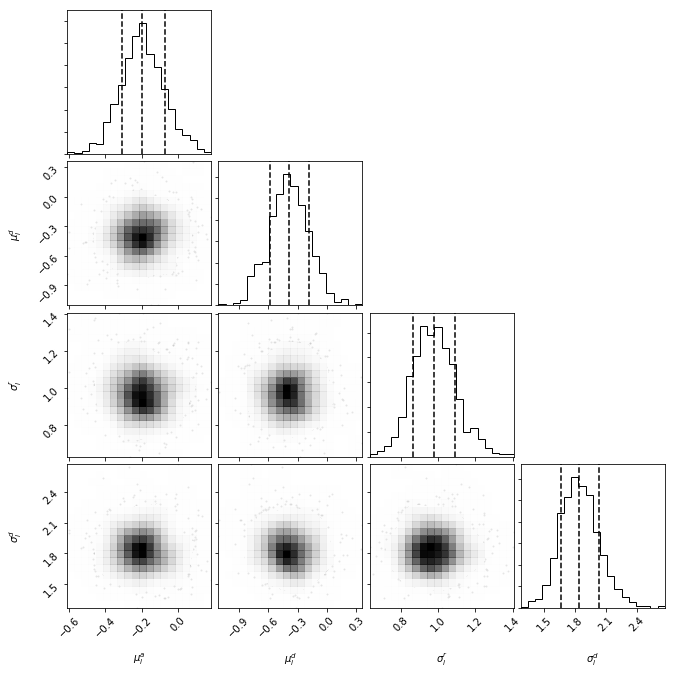

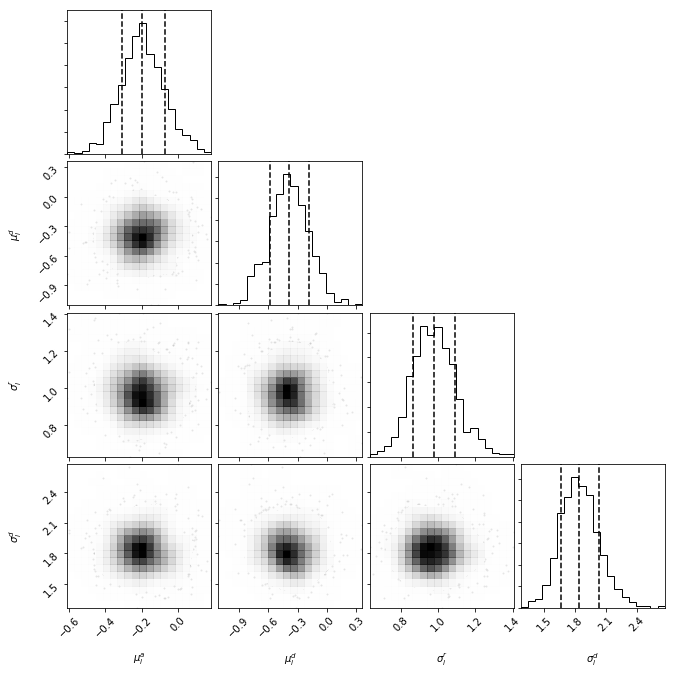

In [15]:
mul=paramslqso['mu']
sigmal=paramslqso['sigma']

pop_params_l = np.vstack([mul[:,0],mul[:,1],sigmal[:,0],sigmal[:,1]])
corner.corner(pop_params_l.T,  
                labels=[r"$\mu_l^a$",r"$\mu_l^d$", 
                        r"$\sigma_l^r$",r"$\sigma_l^d$",
                        ],
                quantiles=[0.16, 0.5, 0.84],
                plot_contours=False, smooth=True)

In [16]:
print('mul ra: ', round(np.mean(mul[:,0]),2),'+/-', round(np.std(mul[:,0]),2))
print('mul dec: ', round(np.mean(mul[:,1]),2), '+/-', round(np.std(mul[:,1]),2))
print('sigmal ra: ', round(np.mean(sigmal[:,0]),2),'+/-', round(np.std(sigmal[:,0]),2))
print('sigmal dec: ', round(np.mean(sigmal[:,1]),2), '+/-', round(np.std(sigmal[:,1]),2))

mul ra:  -0.19 +/- 0.12
mul dec:  -0.38 +/- 0.2
sigmal ra:  0.98 +/- 0.12
sigmal dec:  1.85 +/- 0.19


### The QSO's sample

In [18]:
qsam = np.sort(random.sample(range(Nq),Nl)) #sample subset of allwise objects 

In [19]:
Nsam = len(qsam)
pmhat = np.dstack([allwisenew.pmra[qsam], allwisenew.pmdec[qsam]])[0]
dpmra2 = allwisenew.pmra_error[qsam]**2
dpmdec2 = allwisenew.pmdec_error[qsam]**2
dpmrapmdec = allwisenew.pmra_pmdec_corr[qsam]*allwisenew.pmra_error[qsam]*allwisenew.pmdec_error[qsam]

In [22]:
qsodata={
    'N': Nsam,
    'pmhat': pmhat,
    'Sig': np.reshape(np.dstack([dpmra2,dpmrapmdec, dpmrapmdec, dpmdec2]), [Nsam,2,2])
}

fitqso = sm.sampling(data=qsodata,  iter=2000, chains=1) 

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [23]:
paramsqso = fitqso.extract()

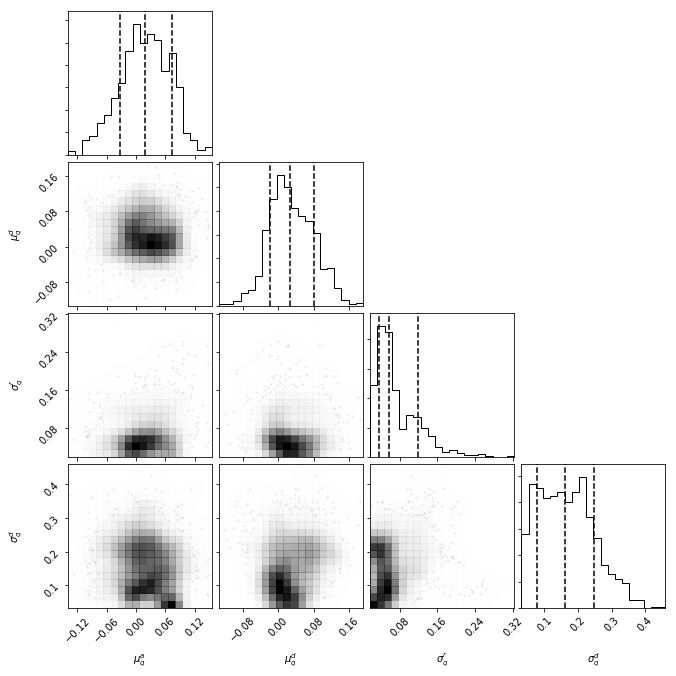

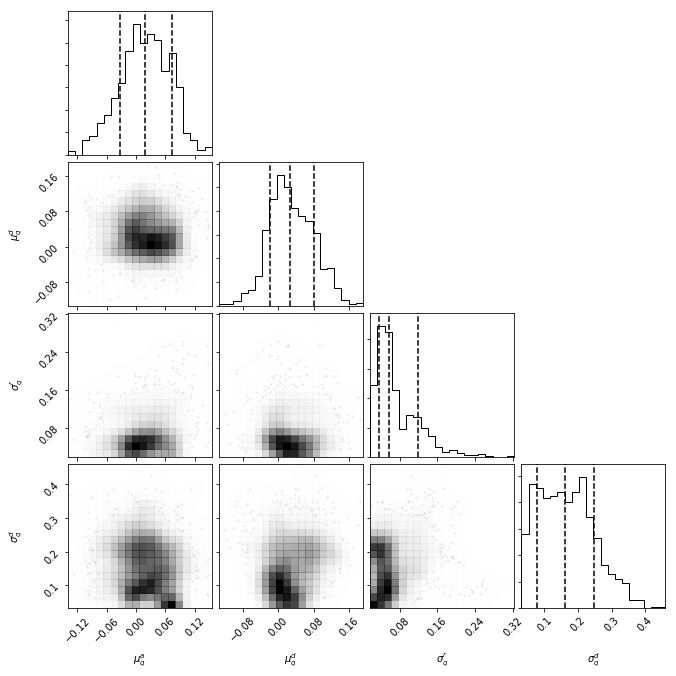

In [24]:
muq=paramsqso['mu']
sigmaq=paramsqso['sigma']

pop_params_q = np.vstack([muq[:,0],muq[:,1],sigmaq[:,0],sigmaq[:,1]])
corner.corner(pop_params_q.T,  
                labels=[r"$\mu_q^a$",r"$\mu_q^d$", 
                        r"$\sigma_q^r$",r"$\sigma_q^d$",
                        ],
                quantiles=[0.16, 0.5, 0.84],
                plot_contours=False, smooth=True)

In [25]:
print('muq ra: ', round(np.mean(muq[:,0]),2),'+/-', round(np.std(muq[:,0]),2))
print('muq dec: ', round(np.mean(muq[:,1]),2), '+/-', round(np.std(muq[:,1]),2))
print('sigmaq ra: ', round(np.mean(sigmaq[:,0]),2),'+/-', round(np.std(sigmaq[:,0]),2))
print('sigmaq dec: ', round(np.mean(sigmaq[:,1]),2), '+/-', round(np.std(sigmaq[:,1]),2))

muq ra:  0.02 +/- 0.05
muq dec:  0.03 +/- 0.05
sigmaq ra:  0.07 +/- 0.05
sigmaq dec:  0.17 +/- 0.08


# the QSO's full sample

In [10]:
pmhat = np.dstack([allwisenew.pmra, allwisenew.pmdec])[0]
dpmra2 = allwisenew.pmra_error**2
dpmdec2 = allwisenew.pmdec_error**2
dpmrapmdec = allwisenew.pmra_pmdec_corr*allwisenew.pmra_error*allwisenew.pmdec_error

In [ ]:
qsodata={
    'N': Nq,
    'pmhat': pmhat,
    'Sig': np.reshape(np.dstack([dpmra2,dpmrapmdec, dpmrapmdec, dpmdec2]), [Nq,2,2])
}

fitqso = sm.sampling(data=qsodata,  iter=2000, chains=1) 

In [ ]:
paramsqso = fitqso.extract()

In [ ]:
muq=paramsqso['mu']
sigmaq=paramsqso['sigma']

pop_params_q = np.vstack([muq[:,0],muq[:,1],sigmaq[:,0],sigmaq[:,1]])
corner.corner(pop_params_q.T,  
                labels=[r"$\mu_q^a$",r"$\mu_q^d$", 
                        r"$\sigma_q^r$",r"$\sigma_q^d$",
                        ],
                quantiles=[0.16, 0.5, 0.84],
                plot_contours=False, smooth=True)

In [ ]:
print('muq ra: ', round(np.mean(muq[:,0]),2),'+/-', round(np.std(muq[:,0]),2))
print('muq dec: ', round(np.mean(muq[:,1]),2), '+/-', round(np.std(muq[:,1]),2))
print('sigmaq ra: ', round(np.mean(sigmaq[:,0]),2),'+/-', round(np.std(sigmaq[:,0]),2))
print('sigmaq dec: ', round(np.mean(sigmaq[:,1]),2), '+/-', round(np.std(sigmaq[:,1]),2))